In [2]:
import torch

## 1. 最原始的softmax

In [3]:
X = torch.tensor([-0.3, 0.2, 0.5, 0.7, 0.1, 0.8])
X_exp_num = torch.exp(X).sum()
X_softmax_hand = torch.exp(X) / X_exp_num
print(X_softmax_hand)

tensor([0.0827, 0.1364, 0.1841, 0.2249, 0.1234, 0.2485])


## 2. safe softmax

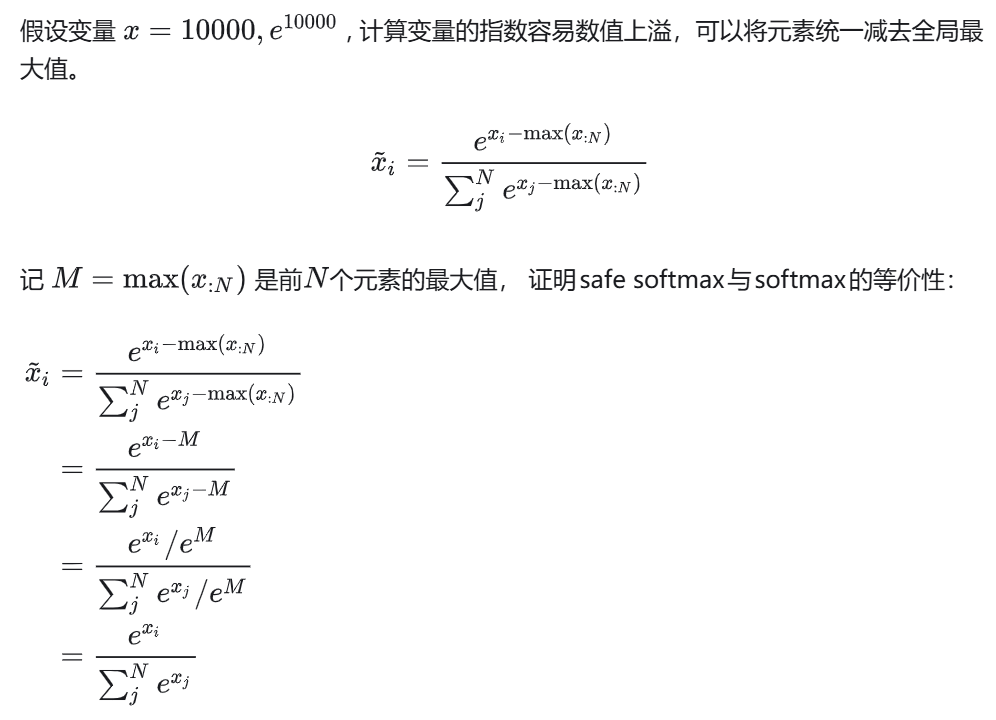

In [4]:
X_max = X.max()
X_exp_sum_sub_max = torch.exp(X - X_max).sum()
X_safe_softmax_hand = torch.exp(X - X_max) / X_exp_sum_sub_max
print(X_safe_softmax_hand)

tensor([0.0827, 0.1364, 0.1841, 0.2249, 0.1234, 0.2485])


## 3. Online softmax

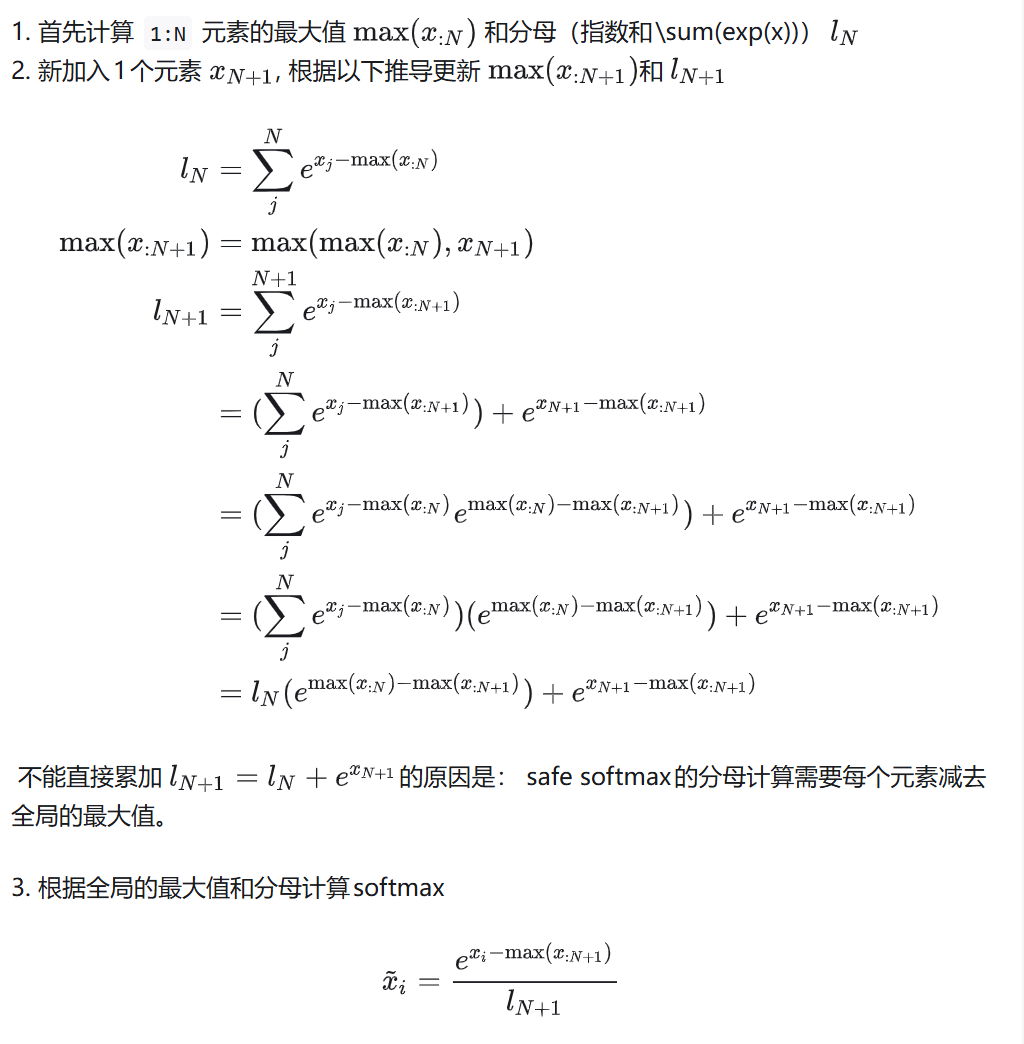

In [5]:
X_pre = X[:-1]
print(X_pre)
print(X[-1])

X_max_pre = X_pre.max()
X_sum_pre = torch.exp(X_pre - X_max_pre).sum()

X_max_cur = torch.max(X_max_pre, X[-1])
X_sum_cur = X_sum_pre * torch.exp(X_max_pre - X_max_cur) + torch.exp(X[-1] - X_max_cur)

X_online_softmax = torch.exp(X - X_max_cur) / X_sum_cur
print(X_online_softmax)

tensor([-0.3000,  0.2000,  0.5000,  0.7000,  0.1000])
tensor(0.8000)
tensor([0.0827, 0.1364, 0.1841, 0.2249, 0.1234, 0.2485])


In [6]:
for i in range(1, len(X)):
    X_pre = X[:i]

    X_max_pre = X_pre.max()
    X_sum_pre = torch.exp(X_pre - X_max_pre).sum()

    X_max_cur = torch.max(X_max_pre, X[i])
    X_sum_cur = X_sum_pre * torch.exp(X_max_pre - X_max_cur) + torch.exp(X[i] - X_max_cur)

    X_online_softmax = torch.exp(X - X_max_cur) / X_sum_cur
    print(X_online_softmax)
output = X_online_softmax
print("final:", output)

tensor([0.3775, 0.6225, 0.8402, 1.0263, 0.5632, 1.1342])
tensor([0.2052, 0.3383, 0.4566, 0.5577, 0.3061, 0.6163])
tensor([0.1317, 0.2172, 0.2931, 0.3580, 0.1965, 0.3957])
tensor([0.1101, 0.1815, 0.2450, 0.2992, 0.1642, 0.3307])
tensor([0.0827, 0.1364, 0.1841, 0.2249, 0.1234, 0.2485])
final: tensor([0.0827, 0.1364, 0.1841, 0.2249, 0.1234, 0.2485])


In [ ]:
# online softmax 2-pass
N = 6
m = torch.tensor(-1000.0)
d = 0
x = torch.randn(N)
a = torch.zeros(N)

print("x:", x)

for i in range(N):
    m_pre = m
    m = torch.max(m_pre, x[i])
    d = d * torch.exp(m_pre - m) + torch.exp(x[i] - m)

for i in range(N):
    a[i] = torch.exp(x[i] - m) / d
print("softmax:", a)
print(torch.sum(a))

x: tensor([ 0.7645, -0.3680,  0.6850,  0.6548,  2.5386,  1.2995])
softmax: tensor([0.0931, 0.0300, 0.0860, 0.0834, 0.5487, 0.1589])
tensor(1.)


### 3.1 block oneline softmax

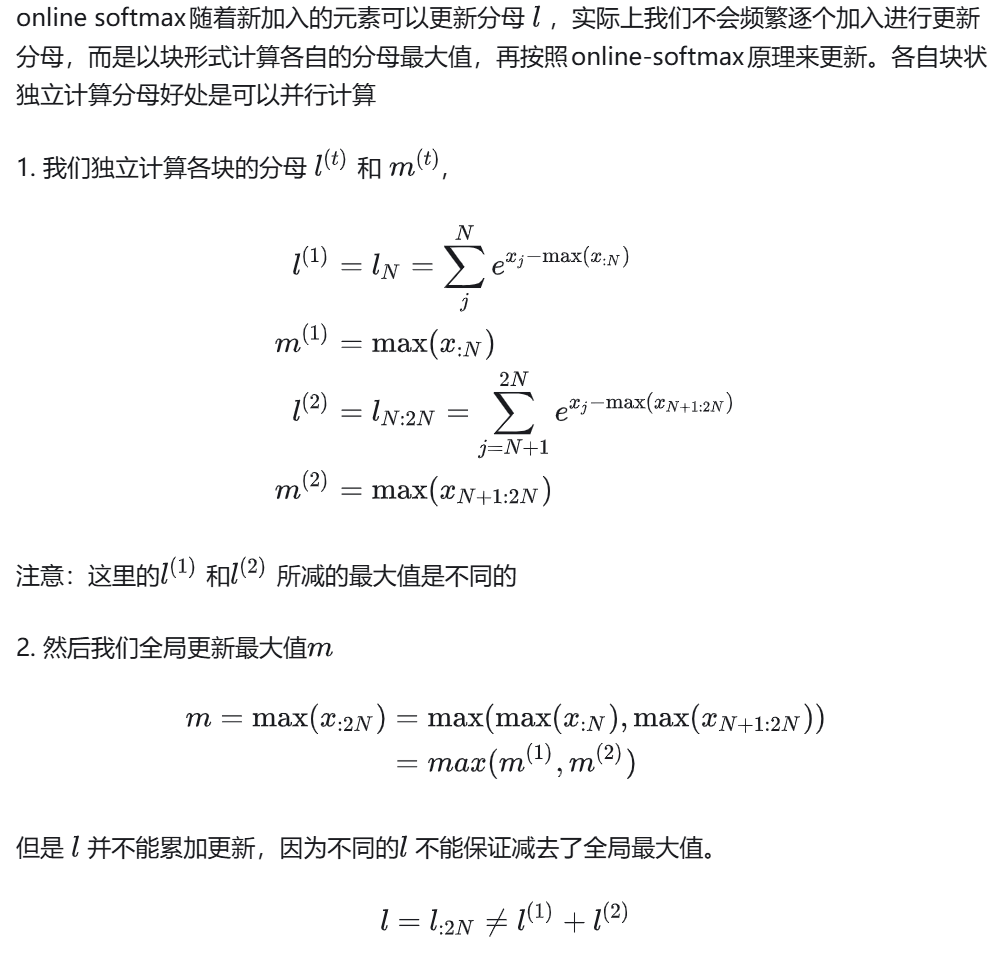
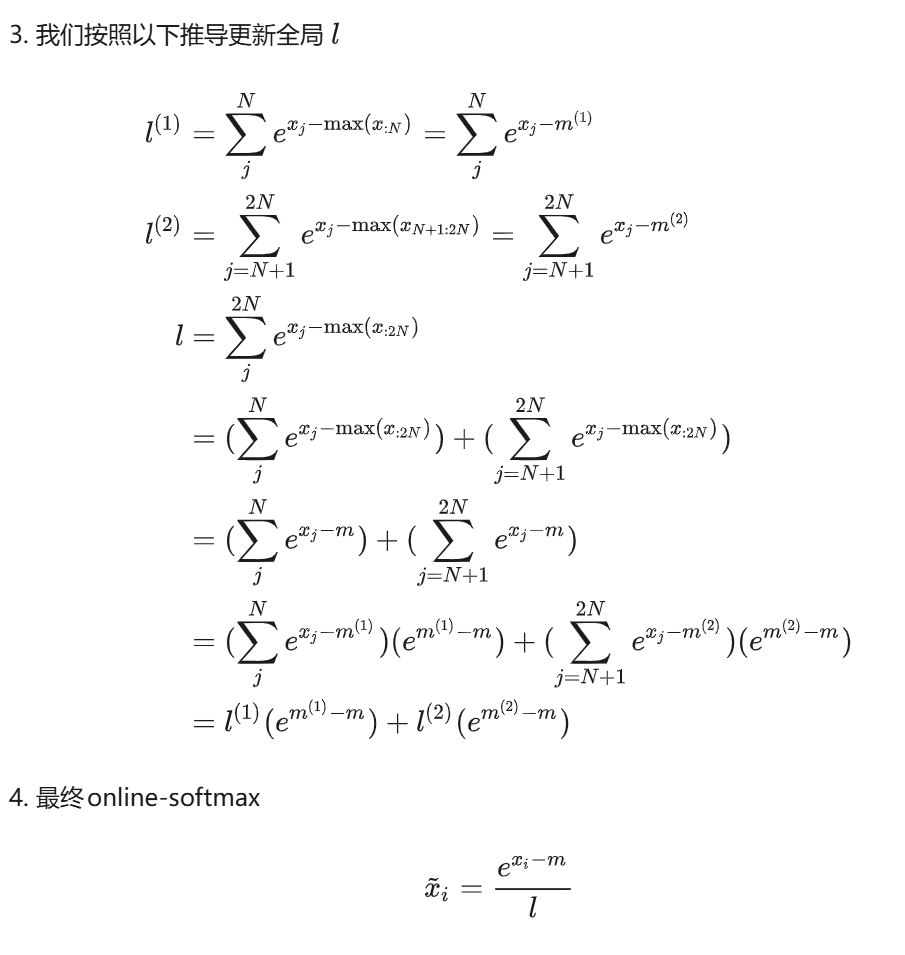

In [8]:
X_block = torch.split(X, split_size_or_sections=3, dim = 0)
print(X_block)

X_block_0_max = X_block[0].max()
X_block_0_sum = torch.exp(X_block[0] - X_block_0_max).sum()

X_block_1_max = X_block[1].max()
X_block_1_sum = torch.exp(X_block[1] - X_block_1_max).sum()

X_block_1_max_update = torch.max(X_block_0_max, X_block_1_max)
X_block_1_sum_update = X_block_0_sum * torch.exp(X_block_0_max - X_block_1_max_update) \
                     + X_block_1_sum * torch.exp(X_block_1_max - X_block_1_max_update)
X_block_online_softmax = torch.exp(X - X_block_1_max_update) / X_block_1_sum_update
print(X_block_online_softmax)

(tensor([-0.3000,  0.2000,  0.5000]), tensor([0.7000, 0.1000, 0.8000]))
tensor([0.0827, 0.1364, 0.1841, 0.2249, 0.1234, 0.2485])


### 3.2 multi-block online softmax

In [9]:
X_block = torch.split(X, split_size_or_sections = 2, dim = 0) 

# we parallel calculate  different block max & sum
X_block_0_max = X_block[0].max()
X_block_0_sum = torch.exp(X_block[0] - X_block_0_max).sum()

X_block_1_max = X_block[1].max()
X_block_1_sum = torch.exp(X_block[1] - X_block_1_max).sum()

X_block_2_max = X_block[2].max()
X_block_2_sum = torch.exp(X_block[2] - X_block_2_max).sum()

M = [X_block_0_max, X_block_1_max, X_block_2_max]
L = [X_block_0_sum, X_block_1_sum, X_block_2_sum]   # L其实没用到

# online multi-block update max & sum
M_old = torch.tensor([0.0])
L_old = torch.tensor([0.0])

for i in range(len(M)):
    M_new = torch.max(M[i], M_old) 
    L_new = L_old * torch.exp(M_old - M_new) \
            + torch.exp(X_block[i] - M_new).sum() # block sum
    M_old = M_new
    L_old = L_new

X_multi_block_online_softmax = torch.exp(X - M_old) / L_old
print(X_multi_block_online_softmax)

tensor([0.0827, 0.1364, 0.1841, 0.2249, 0.1234, 0.2485])


## batch online softmax

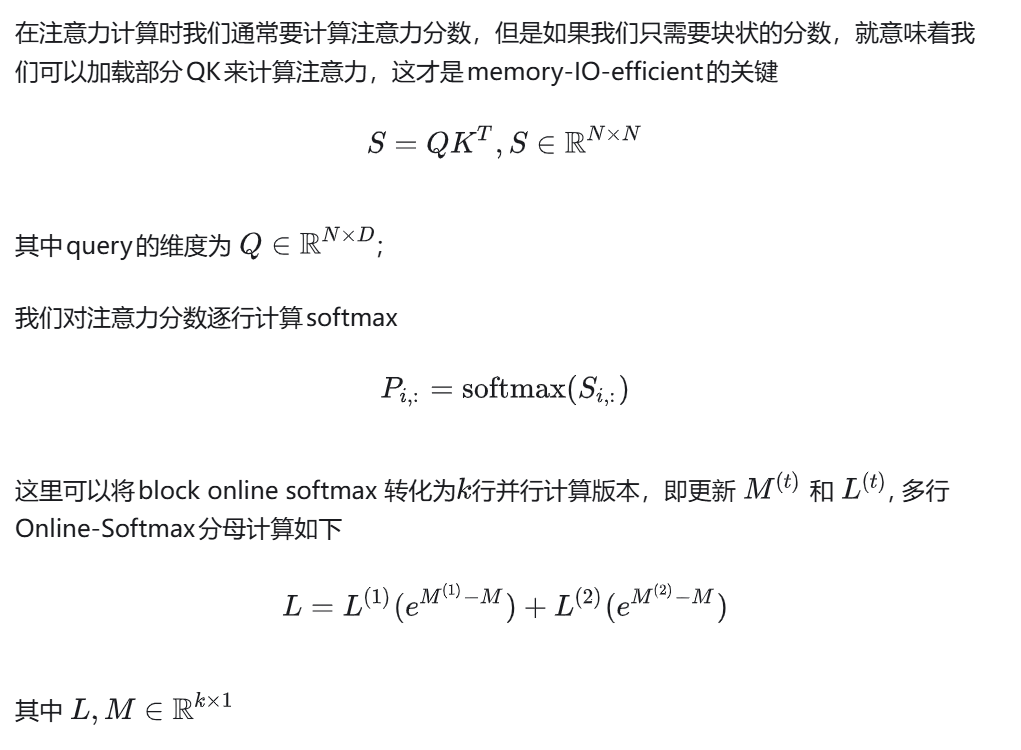

In [10]:
X_batch = torch.randn(4, 6)
_, d = X_batch.shape

X_batch_block_0 = X_batch[:, : d//2]
X_batch_block_1 = X_batch[:, d//2 :]

X_batch_0_max, _ = X_batch_block_0.max(dim = 1, keepdim=True)

print(X_batch_block_0.max(dim = 1, keepdim=False)[0].shape)
print(X_batch_block_0.max(dim = 1, keepdim=True)[0].shape)

X_batch_0_sum = torch.exp(X_batch_block_0 - X_batch_0_max).sum(dim=1, keepdim = True)

X_batch_1_max, _ = X_batch_block_1.max(dim = 1, keepdim = True)
X_batch_1_sum = torch.exp(X_batch_block_1 - X_batch_1_max).sum(dim=1, keepdim = True)

X_batch_1_max_update = torch.max(X_batch_0_max, X_batch_1_max)
X_batch_1_sum_update = X_batch_0_sum * torch.exp(X_batch_0_max - X_batch_1_max_update) \
                     + X_batch_1_sum * torch.exp(X_batch_1_max - X_batch_1_max_update)

X_batch_online_softmax = torch.exp(X_batch - X_batch_1_max_update) / X_batch_1_sum_update
print(X_batch_online_softmax)

torch.Size([4])
torch.Size([4, 1])
tensor([[0.4431, 0.1626, 0.0580, 0.1536, 0.0682, 0.1144],
        [0.0565, 0.3836, 0.1921, 0.0730, 0.0611, 0.2337],
        [0.1437, 0.1539, 0.3364, 0.2341, 0.0191, 0.1128],
        [0.0188, 0.0917, 0.0495, 0.4682, 0.1124, 0.2594]])
